In [1]:
import ast
import os
import glob
import numpy as np
import datetime
import xarray as xr
import nc_time_axis
import itertools
from pathlib import Path
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap
import shapely.geometry as sgeom
import cartopy.crs as ccrs
import cftime
%matplotlib inline

In [2]:
figpath = Path("../figures")

In [3]:
def fix_longitude_jumps(lons, thresh=100):
    """Remove longitude jumps when crossing the Greenwich Meridian
    
    lons (1-d): longitudes
    thresh : maximum expected absolute longitude change per step
    """
    newlons = np.array(lons, copy=True)
    if any(np.abs(np.diff(lons))>thresh):
        for l in range(1,len(newlons)):
            dlon = newlons[l] - newlons[l-1]
            inc = np.sign(int(abs(dlon)>thresh) * dlon)
            if inc != 0:
                newlons[l] = newlons[l] - inc * 360
    return newlons


def track_segments(ds, clevs, x='lon', y='lat', c='PSL', reverse=True):
    """Split all tracks in ds into segments of equal intensity

    input:
    ds : xr.Dataset
        the dataset containing TC tracks
    clevs : Iterable[Numeric]
        levels (bin edges) used to discretize 'c' and segment track data
    x : str
        name of longitude variable
    y : str
        name of latitude variable
    c : str
        name of variable that will be used to segment the track data
    reverse : bool
        by default, track segments having lower values of 'c' are
        output first, this can be reversed by setting reverse=True

    returns:
    """
    ds = ds[[x,y,c]]
    cvals = 0.5 * (clevs[1:] + clevs[:-1])
    
    segments = []
    for tid in ds.id.data:
        # remove longitude jumps when crossing the Greenwich Meridian
        track = ds.sel(id=tid).dropna('dtime')
        track[x].data = fix_longitude_jumps(track[x].data)
        
        # groupby color level consecutively along track
        clev_ids = np.searchsorted(clevs, track[c])
        comb = zip(clev_ids, track[x].data, track[y].data)
        gb = itertools.groupby(comb, key=lambda x: x[0])
        track_segs = [[k,np.vstack(list(dt))[:,1:]] for k,dt in gb]
    
        # insert midway points for smooth joins of segments
        for s,(seg1, seg2) in enumerate(itertools.pairwise(track_segs)):
            ival = np.mean([seg1[1][-1],seg2[1][0]], axis=0)
            track_segs[s][1] = np.vstack([track_segs[s][1], ival])
            track_segs[s+1][1] = np.vstack([ival,track_segs[s+1][1]])
        
        segments += track_segs

    segments = sorted(segments, key=lambda x:x[0], reverse=reverse)
    gb = itertools.groupby(segments, key=lambda x:x[0])
    segments = {c:[segs for _,segs in grp] for c,grp in gb}
    return segments

def savefig(fig, fname, **kwargs):
    """calls fig.savefig(fname, **kwargs) only if fname does not exist"""
    fname = os.path.join(figpath, fname)
    if os.path.exists(fname):
        print(f"{fname} already exists, cannot overwrite")
    else:
        print(f"saving {fname}...")
        fig.savefig(fname, **kwargs)

In [4]:
# read in and merge data
open_kwargs = {
    'Reference': ('RCP',2002,'ref'), 
    'RCP8.5': ('RCP',2092,'rcp'), 
    'SAI2050': ('SAI',2092,'sai')
}

#datadir = "../../tracker/data/"

dsets = {}
for lab,ext in zip(["reg","24","48","inf"],["",".24hrext2",".48hrext2",".infext2"]):
    datadir = f"../../tracker/jobs/Tracking_TC_RV{ext}/"
    print(f'{datadir=}')
    ds = {exp: [] for exp in open_kwargs}
    for exp, (name, year, tag) in open_kwargs.items():
        maxtn = 0
        num_days = 0
        for n in range(1,7):
            #fname = f'{name}.started_{year}.00{n}/TC_tracker_results.{tag}.started_{year}.00{n}.nc'
            if len(ext)>0 and ext[-1] == '2':
                ext = ext[:-1]
            fname = f'TC_tracks.{tag}.00{n}{ext}.nc'
            fname = os.path.join(datadir, fname)
            if os.path.exists(fname):
                dsi = xr.open_dataset(fname, decode_cf=False)
                dsi = (dsi.assign_coords(id=('id',dsi.id.data+maxtn,dsi.id.attrs))
                       .assign_coords(ens=('id',np.ones(dsi.id.size)*n,{'long_name':'ensemble member'})))
                ds[exp].append(dsi)
                maxtn = dsi.id.max().item()
                times = dsi.TC_tracks.isel(data=0)
                num_days += dsi.num_days
                print(f'{tag.upper()}.00{n}: {dsi.num_days/365:.3f} years, {len(dsi.id)} tracks')
            else:
                print(f'no file named {fname}')
        ds[exp] = xr.concat(ds[exp], data_vars='minimal', dim='id', join='outer')
        ds[exp]['num_days'] = num_days.assign_attrs({'long_name':'total number of analysed days'})

    for k,v in ds.items():
        for i,(desc) in enumerate(v.data.description):
            shortname = desc[:desc.index(':')]
            v[shortname] = v.TC_tracks.isel(data=i).assign_attrs(
                ast.literal_eval(desc[desc.index(':')+1:]))
            v[shortname].data[v[shortname]>1e30] = np.nan
        time = v.time.copy()
        time -= 0.0625 # set to center of CESM time bounds (only for year determination)
        tmask = np.isnan(time)
        time.data = cftime.num2date(time.fillna(0), time.units, time.calendar)
        v['year'] = time.dt.year.where(~tmask, np.nan)
        v['PRECT'].data = v['PRECT']*3.6e6 # m/s to mm/hour
        v['PRECT'].attrs.update({'units':'mm/hour'})
    
    
    # check for gaps in track (i.e. last numeric value should be next to first null value)
    for tid in ds['Reference'].id:
        lons = ds['Reference'].lon.sel(id=tid).data
        if not (np.searchsorted(np.isnan(lons), False, side='right') == np.searchsorted(np.isnan(lons), True, side='left')):
            print(f"WARNING: gaps in track {id=}\n{lons=}")

    dsets[lab] = ds

datadir='../../tracker/jobs/Tracking_TC_RV/'
REF.001: 5.000 years, 475 tracks
REF.002: 5.000 years, 484 tracks
REF.003: 5.000 years, 496 tracks
REF.004: 5.000 years, 500 tracks
REF.005: 5.000 years, 523 tracks
REF.006: 5.000 years, 462 tracks
RCP.001: 5.000 years, 445 tracks
RCP.002: 5.000 years, 437 tracks
RCP.003: 5.000 years, 459 tracks
RCP.004: 5.000 years, 464 tracks
RCP.005: 5.000 years, 455 tracks
RCP.006: 5.000 years, 473 tracks
SAI.001: 5.000 years, 425 tracks
SAI.002: 5.000 years, 430 tracks
SAI.003: 5.000 years, 412 tracks
SAI.004: 5.000 years, 430 tracks
SAI.005: 5.000 years, 406 tracks
SAI.006: 5.000 years, 421 tracks
datadir='../../tracker/jobs/Tracking_TC_RV.24hrext2/'
REF.001: 5.000 years, 483 tracks
REF.002: 5.000 years, 490 tracks
REF.003: 5.000 years, 502 tracks
REF.004: 5.000 years, 507 tracks
REF.005: 5.000 years, 529 tracks
REF.006: 5.000 years, 466 tracks
RCP.001: 5.000 years, 452 tracks
RCP.002: 5.000 years, 445 tracks
RCP.003: 5.000 years, 468 tracks
RCP.004: 5

In [5]:

# ################### track figure #######################

# vmin, vmax = 910, 1000
# Nv = round((vmax-vmin)/2.5)+1
# clevels = np.linspace(vmin, vmax, Nv)
# cmap = plt.get_cmap('hot_r')

# fig,axs = plt.subplots(4,1,figsize=(8,10), constrained_layout=True, sharex=True, sharey=True,
#                        subplot_kw={'projection':ccrs.PlateCarree(central_longitude=0),
#                                    'xmargin':0.01, 'ymargin':0.01})
# for exp, ax in zip(dsets, axs):
#     #dsi = select_region(ds[exp], dom)
#     dsi = dsets[exp]['Reference']
#     segments = track_segments(dsi, clevels)
#     for clevid, segs in segments.items():
#         color = cmap((clevid-0.5)/Nv)
#         ax.add_collection(LineCollection(segs, color=color, lw=1, 
#             transform=ccrs.PlateCarree(), capstyle='butt'))
#     ax.set_title(exp)
#     ax.set_title(f'{dsi.id.size/dsi.num_days*365:.0f} TCs/year', loc='right')
#     ax.coastlines()
#     ax.gridlines(draw_labels=(['left','bottom'] if ax==axs[-1] else ['left']))

# for ax in axs: # must be after plotting to prevent setting a global view
#     ax.stock_img()

# # create colorbar
# colors = cmap((np.arange(Nv+1)-0.5)/Nv)
# lcmap = ListedColormap(colors[1:-1])
# lcmap.set_extremes(under=colors[0], over=colors[-1], bad=cmap.get_bad())
# cb = fig.colorbar(plt.cm.ScalarMappable(norm=plt.Normalize(vmin=vmin,vmax=vmax),cmap=lcmap), 
#              ax=axs, extend='both', orientation='horizontal', aspect=50, shrink=1)
# cb.ax.set_title('Sea level pressure [hPa]')

# fname = os.path.join(figpath, 'extension_test.pdf')
# savefig(fig, fname, transparent=True, bbox_inches='tight')

saving ..\figures\..\figures\extension_test.pdf...


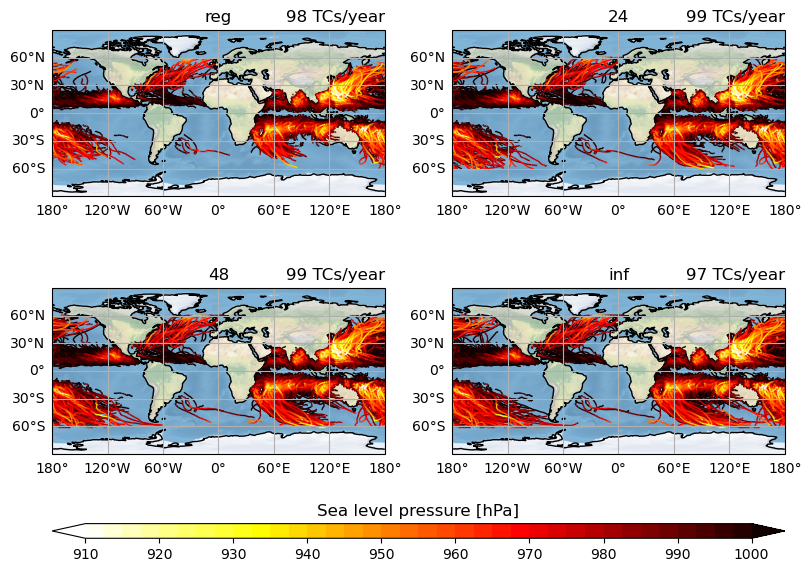

In [6]:
################### track figure #######################

vmin, vmax = 910, 1000
Nv = round((vmax-vmin)/2.5)+1
clevels = np.linspace(vmin, vmax, Nv)
cmap = plt.get_cmap('hot_r')

fig,axs = plt.subplots(2,2,figsize=(8,6), constrained_layout=True, sharex=True, sharey=True,
                       subplot_kw={'projection':ccrs.PlateCarree(central_longitude=0),
                                   'xmargin':0.01, 'ymargin':0.01})

for exp, ax in zip(dsets, axs.flat):
    #dsi = select_region(ds[exp], dom)
    dsi = dsets[exp]['Reference']
    segments = track_segments(dsi, clevels)
    for clevid, segs in segments.items():
        color = cmap((clevid-0.5)/Nv)
        ax.add_collection(LineCollection(segs, color=color, lw=1, 
            transform=ccrs.PlateCarree(), capstyle='butt'))
    ax.set_title(exp)
    ax.set_title(f'{dsi.id.size/dsi.num_days*365:.0f} TCs/year', loc='right')
    ax.coastlines()
    ax.gridlines(draw_labels=(['left','bottom']))

for ax in axs.flat: # must be after plotting to prevent setting a global view
    ax.stock_img()

# create colorbar
colors = cmap((np.arange(Nv+1)-0.5)/Nv)
lcmap = ListedColormap(colors[1:-1])
lcmap.set_extremes(under=colors[0], over=colors[-1], bad=cmap.get_bad())
cb = fig.colorbar(plt.cm.ScalarMappable(norm=plt.Normalize(vmin=vmin,vmax=vmax),cmap=lcmap), 
             ax=axs, extend='both', orientation='horizontal', aspect=50, shrink=1)
cb.ax.set_title('Sea level pressure [hPa]')

fname = os.path.join(figpath, 'extension_test.pdf')
savefig(fig, fname, transparent=True, bbox_inches='tight')

Text(0.5, 0, 'precipitation sum [mm]')

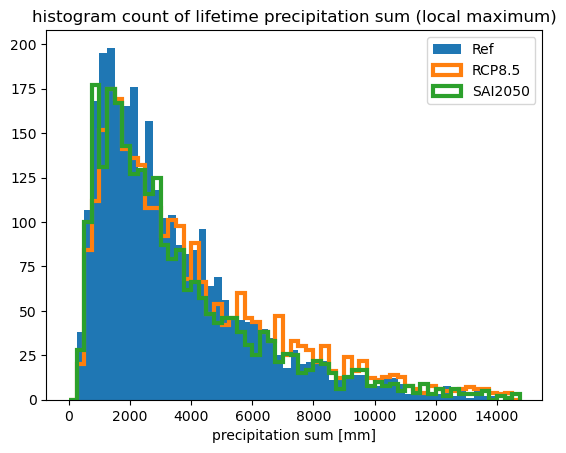

In [118]:
(dsets['reg']['Reference'].PRECT.sum('dtime')*3).plot.hist(bins=range(0,15000,250), label='Ref')
(dsets['reg']['RCP8.5'].PRECT.sum('dtime')*3).plot.hist(bins=range(0,15000,250), label='RCP8.5', histtype='step', lw=3)
(dsets['reg']['SAI2050'].PRECT.sum('dtime')*3).plot.hist(bins=range(0,15000,250), label='SAI2050', histtype='step', lw=3)
plt.legend()
plt.title('histogram count of lifetime precipitation sum (local maximum)')
plt.xlabel('precipitation sum [mm]')